In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [51]:
from google.colab import files
uploaded = files.upload()

Saving data.zip to data.zip


In [52]:
import zipfile
import io

# Extracting the ZIP file
zip_file_name = 'data.zip'
with zipfile.ZipFile(io.BytesIO(uploaded[zip_file_name]), 'r') as zip_ref:
    zip_ref.extractall()

In [54]:
features_df = pd.read_csv('/content/data/features.csv')
train_df = pd.read_csv('/content/data/train.csv')
test_df = pd.read_csv('/content/data/test.csv')

In [55]:
df_aggregated = train_df.groupby(['Store', 'Date'], as_index=False)['Weekly_Sales'].mean()
df_aggregated.rename(columns={'Weekly_Sales': 'Avg_Weekly_Sales'}, inplace=True)
df = pd.merge(df_aggregated, features_df, on=['Store', 'Date'], how='inner')

df.head(10)

,Store,Date,Avg_Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,22516.313699,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,22804.964444,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,22081.755753,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,19579.549861,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,21298.721644,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
5,1,2010-03-12,19719.747808,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,False
6,1,2010-03-19,20451.608194,54.58,2.720,NaN,NaN,NaN,NaN,NaN,211.215635,8.106,False
7,1,2010-03-26,19505.971111,51.45,2.732,NaN,NaN,NaN,NaN,NaN,211.018042,8.106,False
8,1,2010-04-02,22152.337222,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808,False
9,1,2010-04-09,21170.116849,65.86,2.770,NaN,NaN,NaN,NaN,NaN,210.622857,7.808,False


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Store             6435 non-null   int64  
 1   Date              6435 non-null   object 
 2   Avg_Weekly_Sales  6435 non-null   float64
 3   Temperature       6435 non-null   float64
 4   Fuel_Price        6435 non-null   float64
 5   MarkDown1         2280 non-null   float64
 6   MarkDown2         1637 non-null   float64
 7   MarkDown3         2046 non-null   float64
 8   MarkDown4         1965 non-null   float64
 9   MarkDown5         2295 non-null   float64
 10  CPI               6435 non-null   float64
 11  Unemployment      6435 non-null   float64
 12  IsHoliday         6435 non-null   bool   
dtypes: bool(1), float64(10), int64(1), object(1)
memory usage: 609.7+ KB


>>> **a large sum of markdown values are NaN which in this context mean that no markdown was provided during that period**

In [57]:
md_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
df[md_cols] = df[md_cols].fillna(0)
df[md_cols].isnull().sum()

,0
MarkDown1,0
MarkDown2,0
MarkDown3,0
MarkDown4,0
MarkDown5,0


#### Handling missing values in the CPI and Unemployment columns

In [58]:
df['Date'] = pd.to_datetime(df['Date'])

In [59]:
cutoff_date = '2013-05-03'

for store in df['Store'].unique():

    store_data = df[df['Store'] == store]
    # Interpolating CPI and Unemployment for dates before 5/3/2013
    df.loc[(df['Store'] == store) & (df['Date'] < cutoff_date), 'CPI'] = \
    store_data.loc[store_data['Date'] < cutoff_date, 'CPI'].interpolate(method='linear')

    df.loc[(df['Store'] == store) & (df['Date'] < cutoff_date), 'Unemployment'] = \
    store_data.loc[store_data['Date'] < cutoff_date, 'Unemployment'].interpolate(method='linear')

In [60]:
# Forward filling CPI and Unemployment for each store individually
df['CPI'] = df.groupby('Store')['CPI'].fillna(method='ffill')
df['Unemployment'] = df.groupby('Store')['Unemployment'].fillna(method='ffill')

<ipython-input-60-5948a15dc572>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['CPI'] = df.groupby('Store')['CPI'].fillna(method='ffill')
<ipython-input-60-5948a15dc572>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Unemployment'] = df.groupby('Store')['Unemployment'].fillna(method='ffill')


In [61]:
print(f"CPI null: {df['CPI'].isnull().sum()}")
print(f"Unemp null: {df['Unemployment'].isnull().sum()}")

CPI null: 0
Unemp null: 0


In [62]:
df.tail(5)

,Store,Date,Avg_Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
6430,45,2012-09-28,10805.665909,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,False
6431,45,2012-10-05,10786.103971,64.89,3.985,5046.74,0.00,18.82,2253.43,2340.01,192.170412,8.667,False
6432,45,2012-10-12,11128.247879,54.47,4.000,1956.28,0.00,7.89,599.32,3990.54,192.327265,8.667,False
6433,45,2012-10-19,10880.689848,56.47,3.969,2004.02,0.00,3.18,437.73,1537.49,192.330854,8.667,False
6434,45,2012-10-26,11347.484030,58.85,3.882,4018.91,58.08,100.00,211.94,858.33,192.308899,8.667,False


In [63]:
df['Avg_Weekly_Sales'].describe()

,Avg_Weekly_Sales
count,6435.000000
mean,15438.235889
std,7293.360012
min,4072.448594
25%,9437.672870
50%,13981.704667
75%,20073.017942
max,54552.663571


### Visualising Data


#### department performance comparison

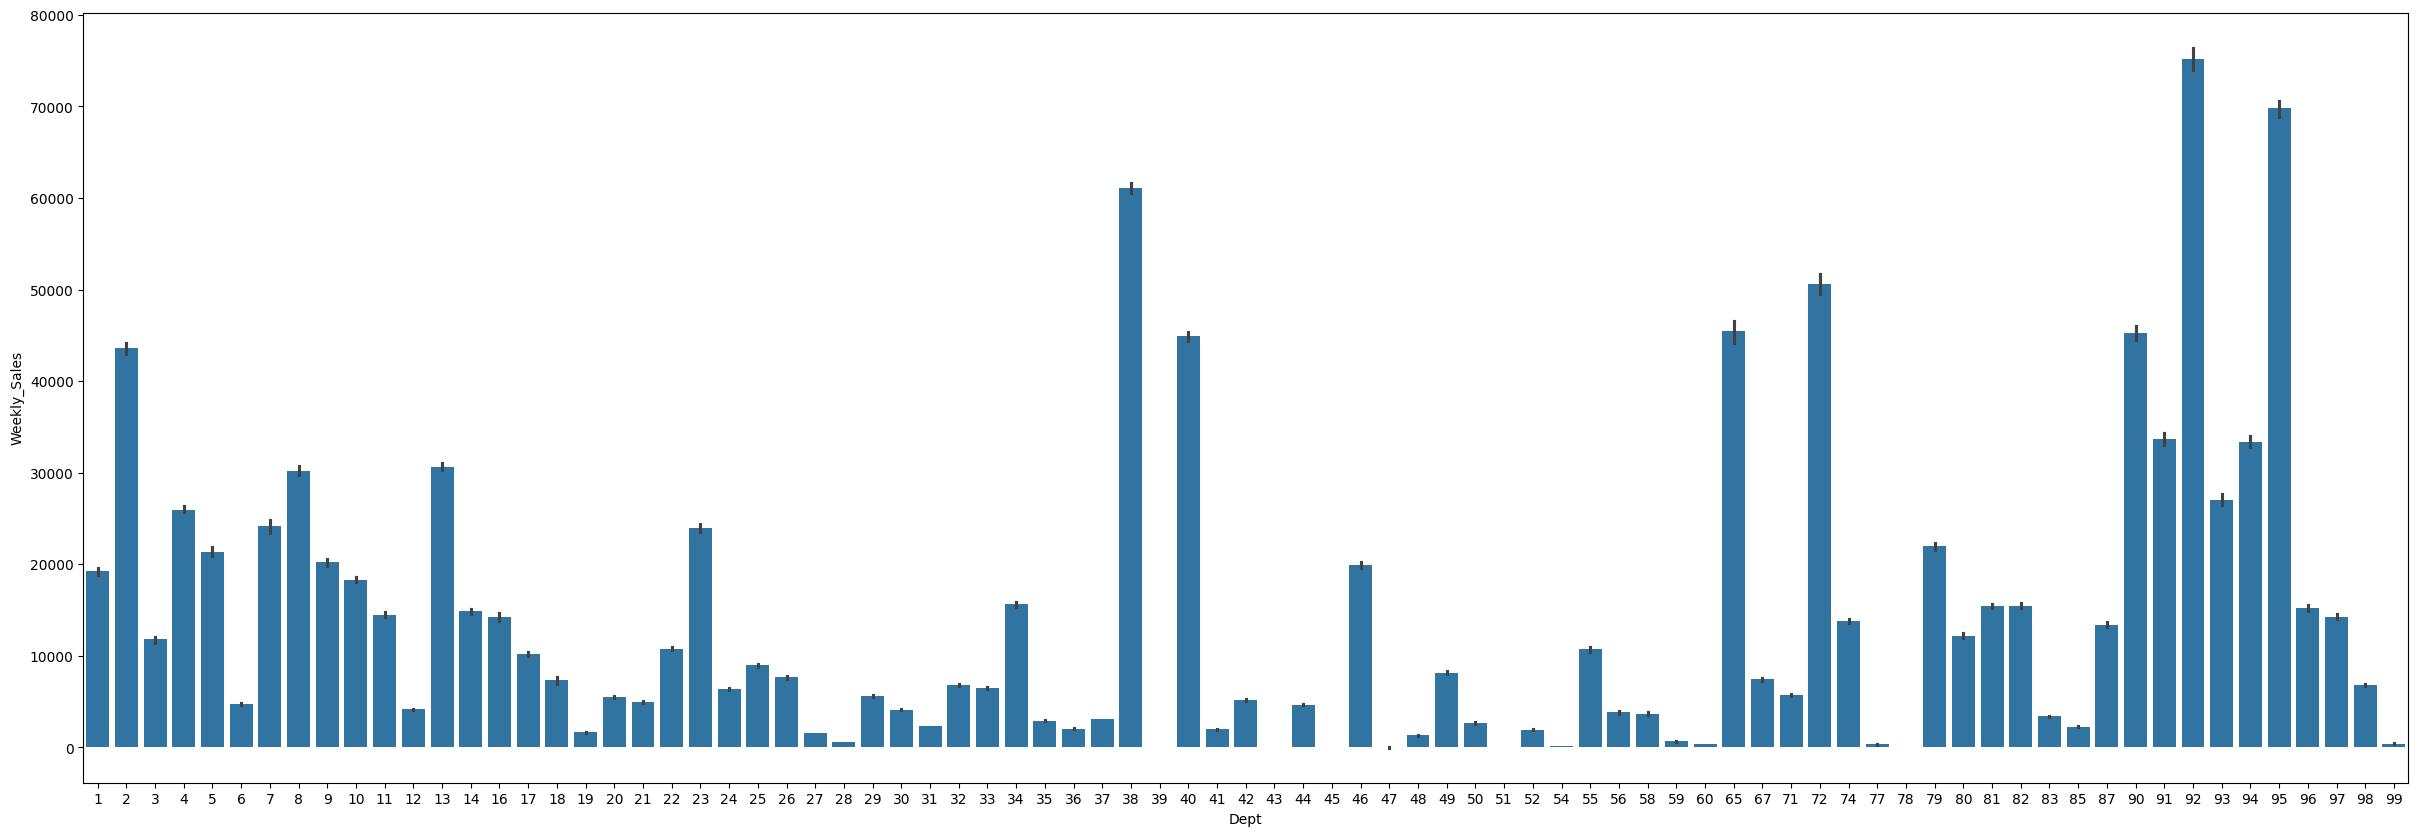

In [64]:
plt.figure(figsize=(30,10))
fig = sns.barplot(x='Dept', y='Weekly_Sales', data=train_df)

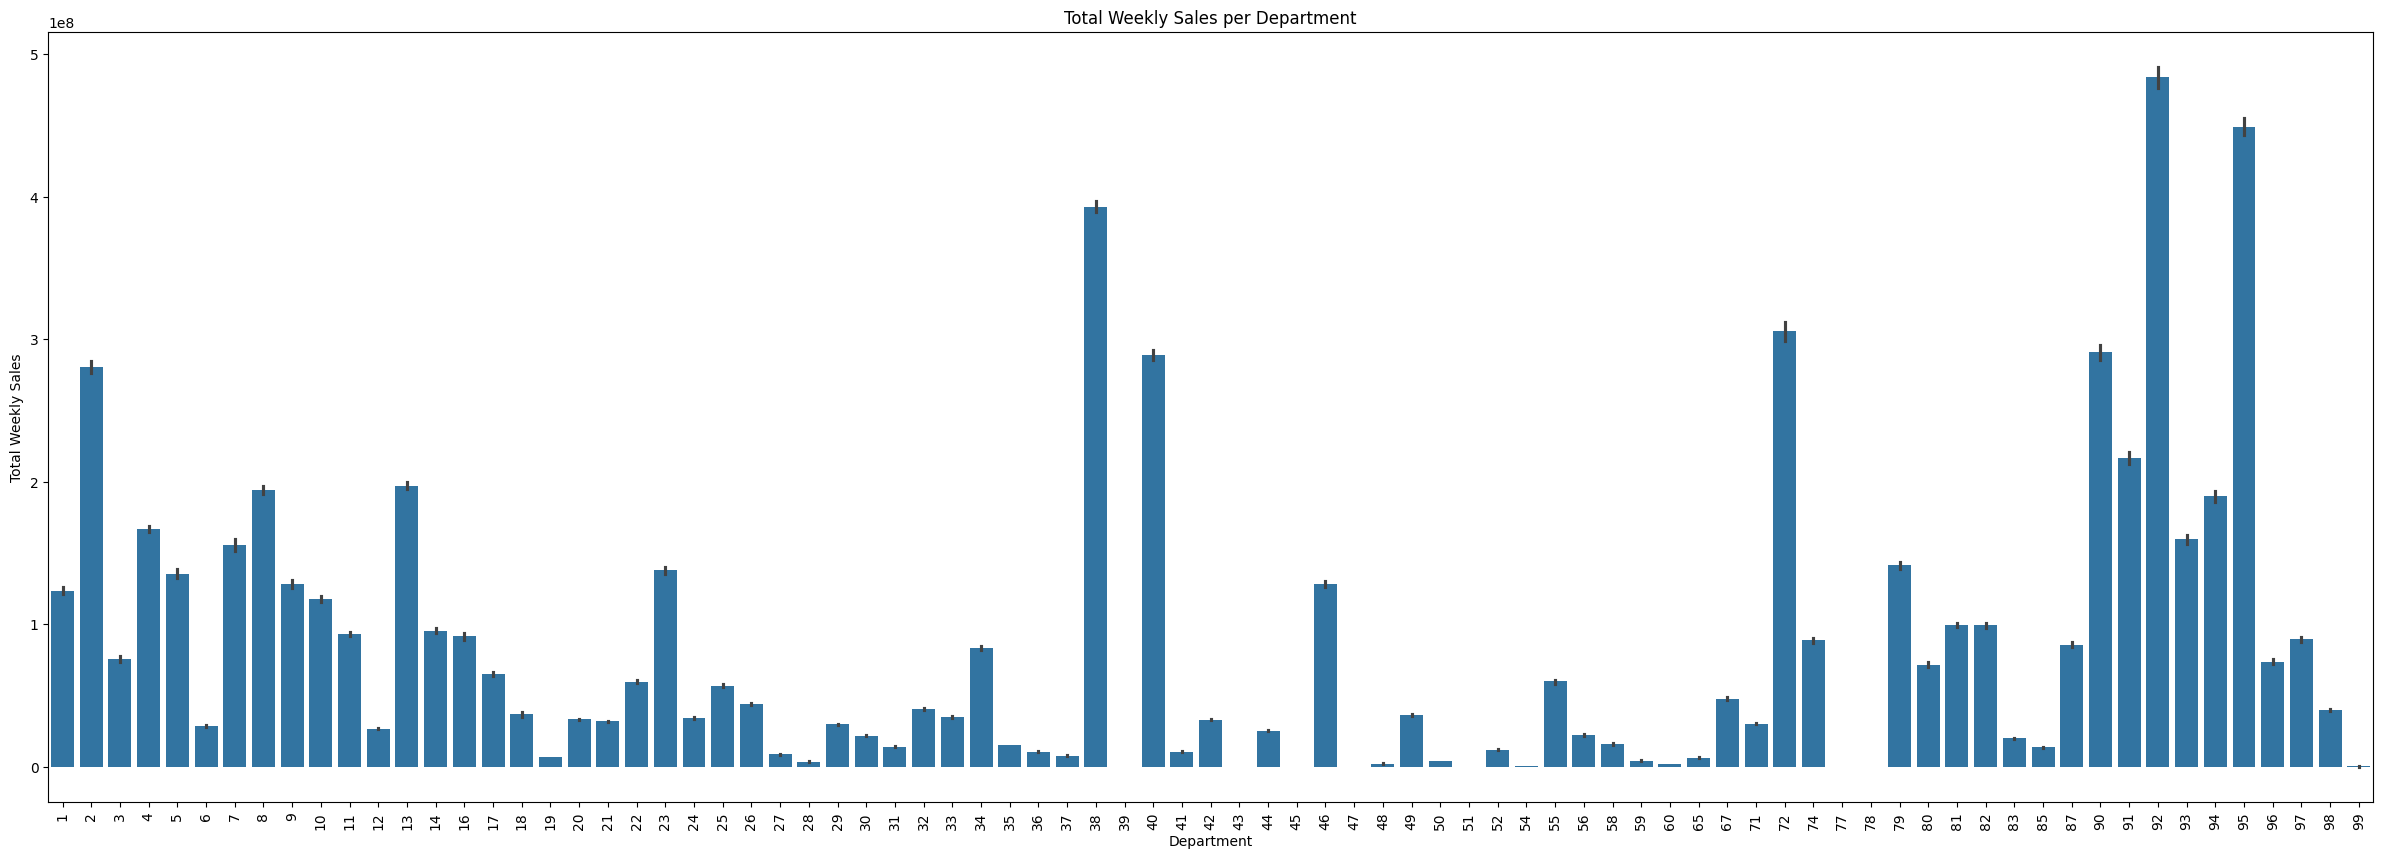

In [65]:
plt.figure(figsize=(30, 10))
sns.barplot(x='Dept', y='Weekly_Sales', data=train_df, estimator=sum)
plt.title('Total Weekly Sales per Department')
plt.xlabel('Department')
plt.ylabel('Total Weekly Sales')
plt.xticks(rotation=90)
plt.show()

>>> **Some of the highest performing departments are 2, 38, 40, 72, 90, 92, and 95.**

#### store performance comparison

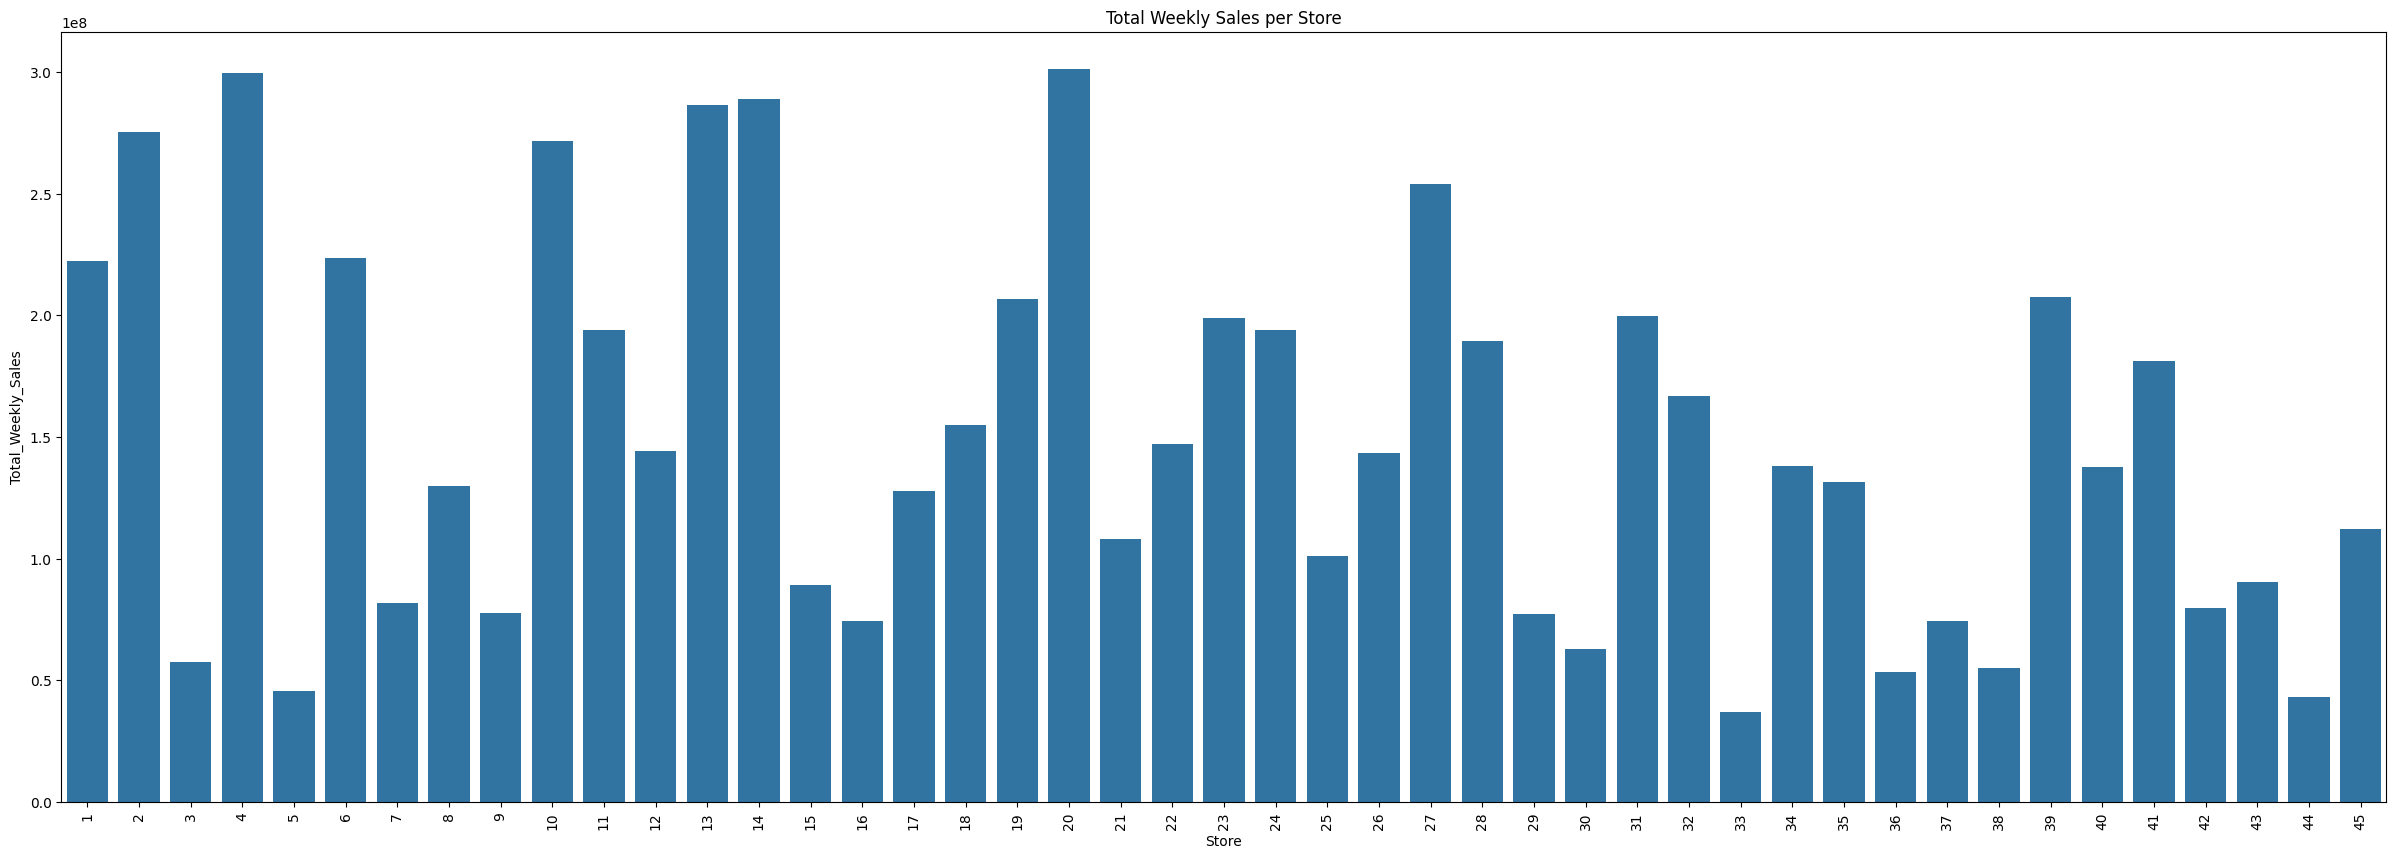

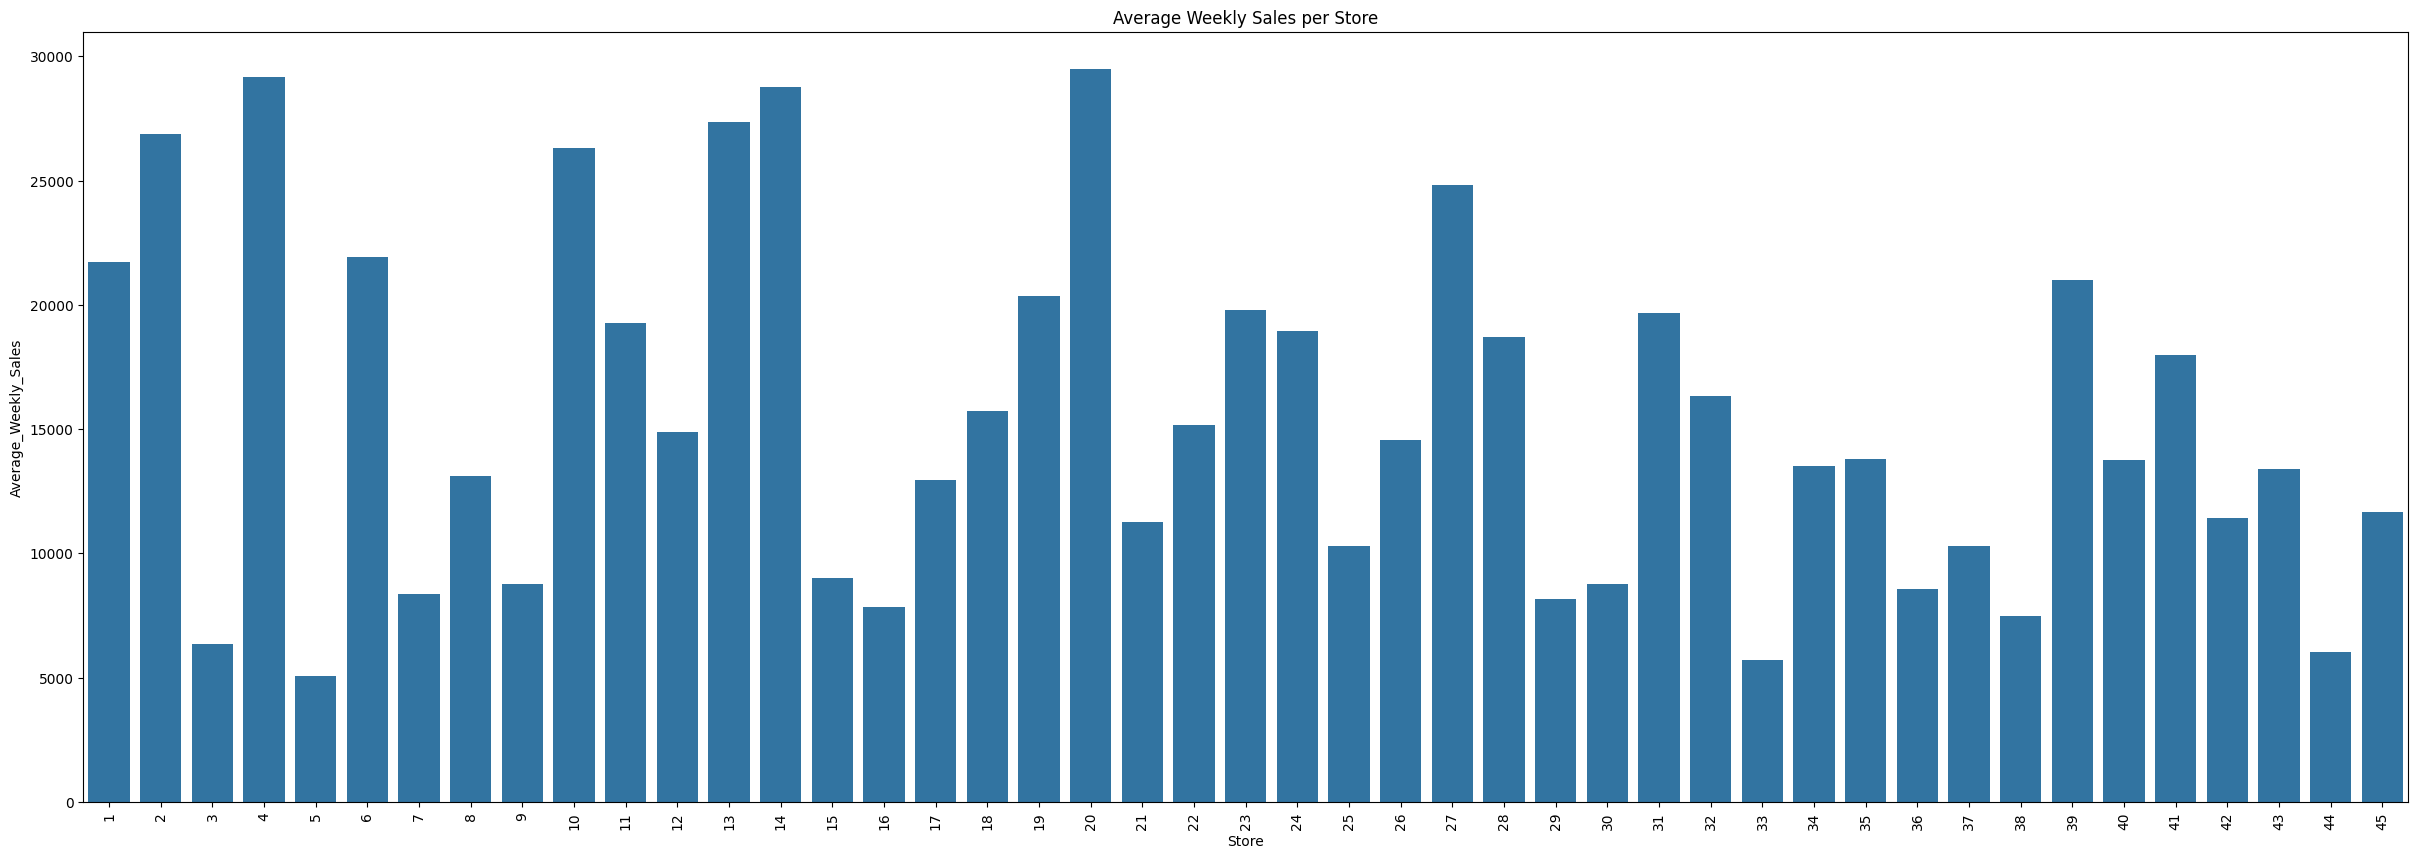

In [66]:
# Plotting total sales for each store
store_sales = train_df.groupby('Store')['Weekly_Sales'].sum().reset_index()
store_sales.columns = ['Store', 'Total_Weekly_Sales']
plt.figure(figsize=(30, 10))
sns.barplot(x='Store', y='Total_Weekly_Sales', data=store_sales)
plt.title('Total Weekly Sales per Store')
plt.xticks(rotation=90)
plt.show()

# Plotting average weekly sales for each store
average_sales = train_df.groupby('Store')['Weekly_Sales'].mean().reset_index()
average_sales.columns = ['Store', 'Average_Weekly_Sales']
plt.figure(figsize=(30, 10))
sns.barplot(x='Store', y='Average_Weekly_Sales', data=average_sales)
plt.title('Average Weekly Sales per Store')
plt.xticks(rotation=90)
plt.show()

>>>  **The stores that generate the most revenue are 1, 2, 4, 6, 10, 13, 14, 20, 27, and 39**

#### Date influence on sales

In [67]:
df['Date'] = pd.to_datetime(df['Date'])
df['month'] =df['Date'].dt.month
df['year'] =df['Date'].dt.year
df['day'] =df['Date'].dt.day
df.groupby('month')['Avg_Weekly_Sales'].mean()

,Avg_Weekly_Sales
month,
1,13710.278699
2,15466.190339
3,14912.548622
4,15129.736205
5,15257.226144
6,15770.756230
7,15325.177515
8,15509.340645
9,14605.106889


<Axes: xlabel='month'>

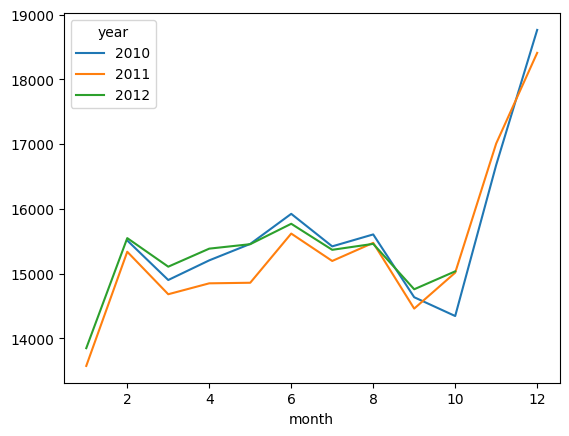

In [68]:
monthly_sales = pd.pivot_table(df, values = "Avg_Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()

>>> **as seen from the graph above, sales seem to be higher during the end of the year**

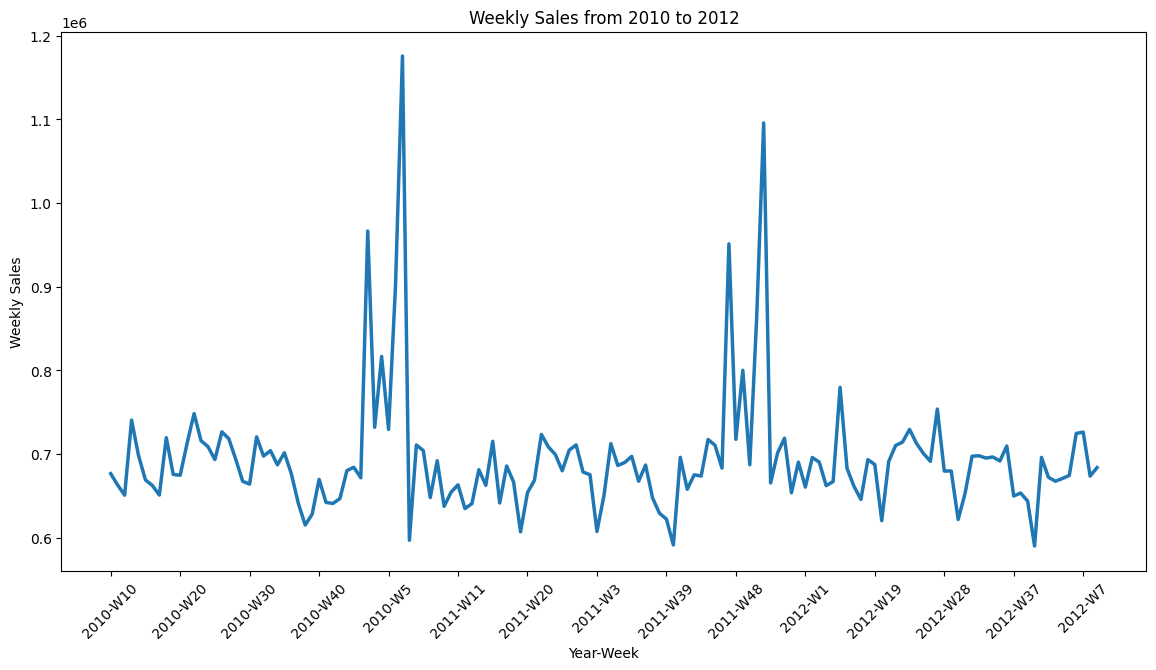

In [69]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Week'] = df['Date'].dt.isocalendar().week

df['Year_Week'] = df['Year'].astype(str) + '-W' + df['Week'].astype(str)
weekly_sales = df.groupby('Year_Week')['Avg_Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(14, 7))
sns.lineplot(x='Year_Week', y='Avg_Weekly_Sales', data=weekly_sales, linewidth=2.5)
plt.title("Weekly Sales from 2010 to 2012")
plt.xlabel("Year-Week")
plt.ylabel("Weekly Sales")
plt.xticks(ticks=range(0, len(weekly_sales), 10), rotation=45)
plt.show()

>>> **This confirms the rise in sales during the end of the year. this is due to holidays such as Thanksgiving week (First Spike of pair) and Christmas week (Second Spike of pair) during the last months of the year**

#### visualizing feeature corellation

In [70]:
df.drop(['Date', 'Year', 'Week', 'Year_Week'], axis=1, inplace=True)

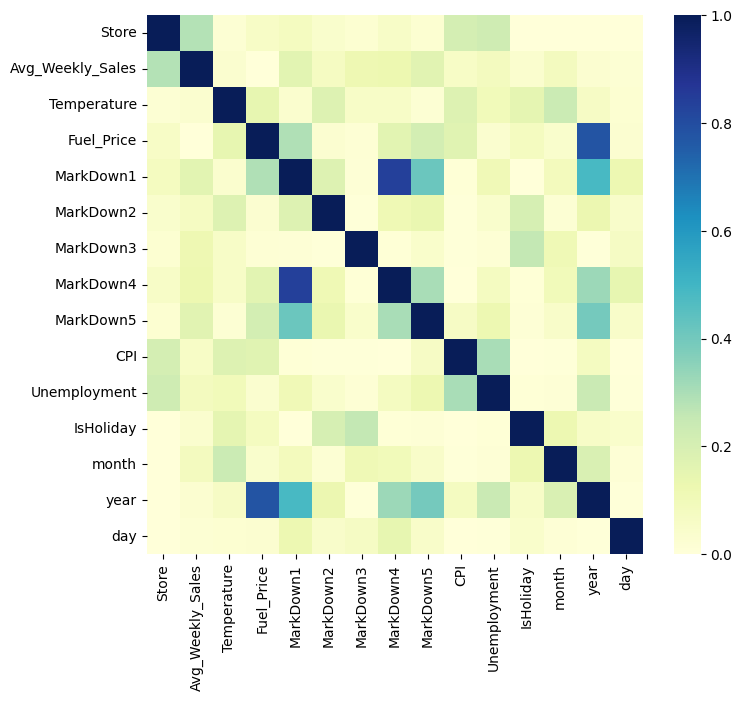

In [71]:
plt.figure(figsize = (8,7))
sns.heatmap(df.corr().abs(), cmap='YlGnBu')    # To see the correlations
plt.show()

 there is no significant corellation between features of this dataset

#### Modelling

In [72]:
X = df[['Store', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'CPI', 'Unemployment', 'IsHoliday']]
y = df['Avg_Weekly_Sales']

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [77]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [78]:
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'R²: {r2}')
print(f'RMSE: {rmse}')

R²: 0.12924699301895848
RMSE: 6834.197998567166


In [79]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
print(coefficients.sort_values(by='Coefficient', ascending=False))

        Feature  Coefficient
3     MarkDown1  1136.575598
5     MarkDown3   846.396347
4     MarkDown2   290.399719
1   Temperature   192.289900
8     IsHoliday   -32.445093
7  Unemployment  -416.141893
2    Fuel_Price  -520.979569
6           CPI -1067.736506
0         Store -1994.185664


>**Although the model accuracy is very bad, the feature weights give us some insight into the data:**

- **MarkDowns**: The positive coefficients for MarkDown1, MarkDown2, and MarkDown3 indicate that markdowns (promotional discounts) positively influence the target variable (e.g., sales). ***The larger the markdown, the higher the sales.***

- **Temperature**: An increase in temperature positively affects the target, likely because ***higher temperatures might increase consumer spending*** or visits to stores.

- **IsHoliday**: A holiday period has a small negative impact on the target, which is somewhat counterintuitive, as we might expect holidays to boost sales. However, this may depend on the nature of the business or other external factors.

- **Unemployment and CPI**: Both unemployment and CPI have strong negative effects, meaning that ***higher unemployment and a higher CPI*** (indicating inflation) ***lead to lower sales or performance in the target variable.***

- **Fuel Price**: Higher fuel prices also negatively affect the target variable, likely because ***consumers have less disposable income when fuel prices are high.***

#### Trying to build a better model

In [80]:
cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
df_numeric = df[cols]

from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(standardize=True)
df_transformed = pd.DataFrame(pt.fit_transform(df_numeric), columns=cols)
transformation_lambdas = pd.DataFrame({'cols': cols, 'box-cox lambda': pt.lambdas_})
print(transformation_lambdas)

for col in cols:
    df[col] = df_transformed[col]

           cols  box-cox lambda
0   Temperature        1.310227
1    Fuel_Price        1.312414
2           CPI       -0.072866
3  Unemployment       -0.253970


In [81]:
X = df[['Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday']]
y = df['Avg_Weekly_Sales']

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


transformer = ColumnTransformer(transformers=[('tf', OneHotEncoder(sparse=False, drop='first'), ['Store'])], remainder='passthrough')

X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

new_columns = transformer.named_transformers_['tf'].get_feature_names_out(['Store'])
remainder_columns = X_train.drop(['Store'], axis=1).columns
all_columns = list(new_columns) + list(remainder_columns)

X_train = pd.DataFrame(X_train_transformed, columns=all_columns)
X_test = pd.DataFrame(X_test_transformed, columns=all_columns)

print("Transformed training shape:", X_train.shape)
print("Transformed testing shape:", X_test.shape)


Transformed training shape: (5148, 49)
Transformed testing shape: (1287, 49)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [84]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [85]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [86]:
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'R²: {r2}')
print(f'RMSE: {rmse}')

R²: 0.9058388527814006
RMSE: 2247.3770212840027


In [87]:
coefficients = pd.DataFrame({
    'Feature': remainder_columns,
    'Coefficient': model.coef_[len(new_columns):]
})
print(coefficients.sort_values(by='Coefficient', ascending=False))

        Feature  Coefficient
2           CPI   579.598620
4     IsHoliday   238.880560
0   Temperature  -141.192982
1    Fuel_Price  -288.252707
3  Unemployment  -621.760059


In [88]:
print(X_train.columns)

Index(['Store_2', 'Store_3', 'Store_4', 'Store_5', 'Store_6', 'Store_7',
       'Store_8', 'Store_9', 'Store_10', 'Store_11', 'Store_12', 'Store_13',
       'Store_14', 'Store_15', 'Store_16', 'Store_17', 'Store_18', 'Store_19',
       'Store_20', 'Store_21', 'Store_22', 'Store_23', 'Store_24', 'Store_25',
       'Store_26', 'Store_27', 'Store_28', 'Store_29', 'Store_30', 'Store_31',
       'Store_32', 'Store_33', 'Store_34', 'Store_35', 'Store_36', 'Store_37',
       'Store_38', 'Store_39', 'Store_40', 'Store_41', 'Store_42', 'Store_43',
       'Store_44', 'Store_45', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'IsHoliday'],
      dtype='object')


#### calculating the Variance Inflation Factor (VIF)

In [89]:
!pip install -q statsmodels --upgrade

In [90]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

In [91]:
feature_columns = ['Store_2', 'Store_3', 'Store_4', 'Store_5', 'Store_6', 'Store_7',
                   'Store_8', 'Store_9', 'Store_10', 'Store_11', 'Store_12', 'Store_13',
                   'Store_14', 'Store_15', 'Store_16', 'Store_17', 'Store_18', 'Store_19',
                   'Store_20', 'Store_21', 'Store_22', 'Store_23', 'Store_24', 'Store_25',
                   'Store_26', 'Store_27', 'Store_28', 'Store_29', 'Store_30', 'Store_31',
                   'Store_32', 'Store_33', 'Store_34', 'Store_35', 'Store_36', 'Store_37',
                   'Store_38', 'Store_39', 'Store_40', 'Store_41', 'Store_42', 'Store_43',
                   'Store_44', 'Store_45', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday']

vif_data = calculate_vif(pd.DataFrame(X_train_scaled, columns=feature_columns))
print(vif_data)

         Feature         VIF
0        Store_2    1.977158
1        Store_3    2.007169
2        Store_4   83.471652
3        Store_5    2.230709
4        Store_6    2.167846
5        Store_7    5.217608
6        Store_8    2.254128
7        Store_9    2.221524
8       Store_10   74.819909
9       Store_11    2.110635
10      Store_12   69.279611
11      Store_13   86.496191
12      Store_14    7.529219
13      Store_15   69.548665
14      Store_16    6.549537
15      Store_17   82.576309
16      Store_18   63.474827
17      Store_19   62.556942
18      Store_20    2.488228
19      Store_21    1.959586
20      Store_22   57.864324
21      Store_23   76.894295
22      Store_24   64.789761
23      Store_25    2.515469
24      Store_26   66.522737
25      Store_27   57.836654
26      Store_28   66.746180
27      Store_29   63.404797
28      Store_30    2.064164
29      Store_31    1.950486
30      Store_32    5.104960
31      Store_33   76.014605
32      Store_34   73.491720
33      Store_

#### implementing Ridge regression seeing VIF scores

In [92]:
from sklearn.linear_model import Ridge, Lasso

# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

ridge_r2 = r2_score(y_test, y_pred_ridge)
ridge_rmse = mean_squared_error(y_test, y_pred_ridge, squared=False)
print(f'Ridge Regression R²: {ridge_r2}')
print(f'Ridge Regression RMSE: {ridge_rmse}')

Ridge Regression R²: 0.9058327002984622
Ridge Regression RMSE: 2247.450441815361


In [99]:
from sklearn.linear_model import Lasso

# Lasso Regression
lasso_model = Lasso(alpha=5.0)
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

lasso_r2 = r2_score(y_test, y_pred_lasso)
lasso_rmse = mean_squared_error(y_test, y_pred_lasso, squared=False)
print(f'Lasso Regression R²: {lasso_r2}')
print(f'Lasso Regression RMSE: {lasso_rmse}')

Lasso Regression R²: 0.9056205158636085
Lasso Regression RMSE: 2249.9810743917274


In [94]:
lasso_coefficients = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': lasso_model.coef_
})
print(lasso_coefficients[lasso_coefficients['Coefficient'] != 0].sort_values(by='Coefficient', ascending=False))

         Feature  Coefficient
2        Store_4  2029.630165
11      Store_13  1858.815374
18      Store_20  1615.280003
46           CPI  1607.417616
8       Store_10  1605.794367
12      Store_14  1576.074759
25      Store_27  1390.626068
0        Store_2  1158.454157
17      Store_19   702.913906
21      Store_23   614.092190
26      Store_28   539.783790
22      Store_24   508.375635
4        Store_6   460.372180
37      Store_39   322.324413
48     IsHoliday   209.120635
29      Store_31   107.653509
9       Store_11    64.974499
16      Store_18    50.367057
44   Temperature   -23.926648
24      Store_26   -42.184532
47  Unemployment   -45.081560
32      Store_34  -163.991667
38      Store_40  -180.161629
30      Store_32  -181.166613
45    Fuel_Price  -204.120405
33      Store_35  -206.818419
15      Store_17  -247.946847
40      Store_42  -437.478675
41      Store_43  -684.809435
6        Store_8  -773.491878
43      Store_45  -821.265399
13      Store_15  -868.838643
19      St

#### trying to improve accuracy using XGboost

In [95]:
!pip install -q xgboost

In [96]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error

dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.09,
    'max_depth': 17,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

params['min_child_weight'] = 9
params['lambda'] = 8.0
params['alpha'] = 0.01

num_rounds = 350
xgboost_model = xgb.train(params, dtrain, num_rounds)

y_pred_xgb = xgboost_model.predict(dtest)

xgb_r2 = r2_score(y_test, y_pred_xgb)
xgb_rmse = mean_squared_error(y_test, y_pred_xgb, squared=False)

print(f'XGBoost R²: {xgb_r2}')
print(f'XGBoost RMSE: {xgb_rmse}')

XGBoost R²: 0.9492602248663354
XGBoost RMSE: 1649.7355556705934


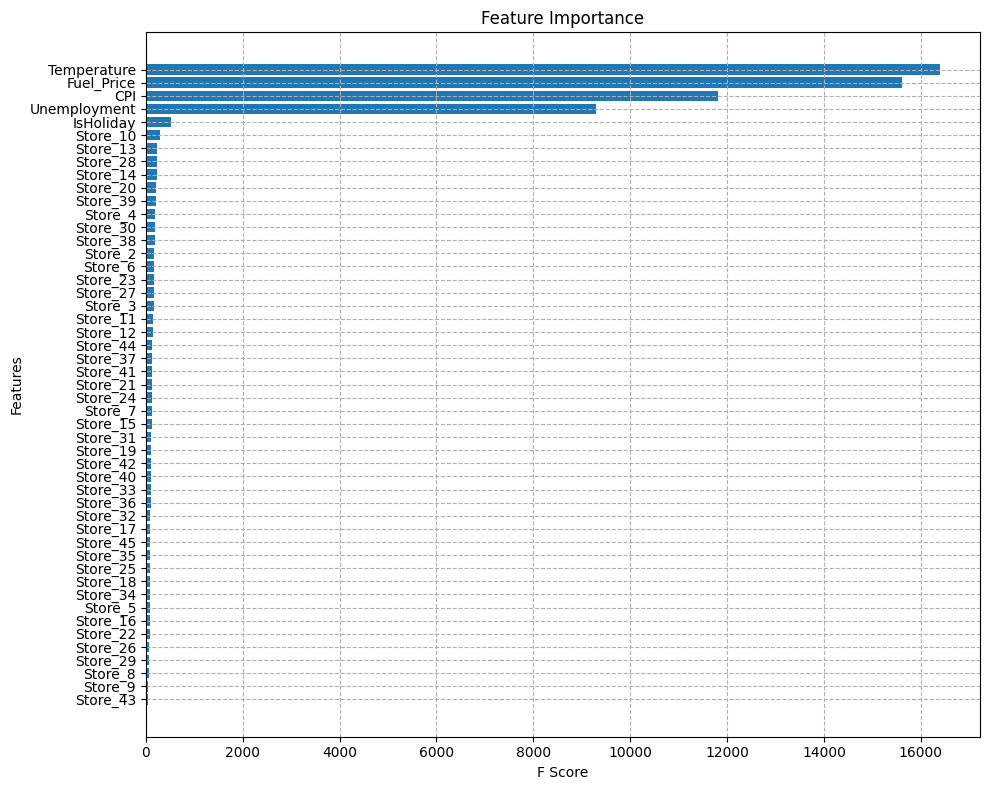

In [103]:
importance = xgboost_model.get_score(importance_type='weight')

feature_importance = pd.DataFrame({
    'Feature': [feature_columns[int(f[1:])] for f in importance.keys()],
    'Importance': importance.values()
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('F Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

> **Based on the XGBoost model's feature importance plot, we can derive the following insights:**

- **Temperature** is the most significant predictor in the model, indicating that fluctuations in temperature strongly impact sales. This suggests consumer behavior may change significantly with weather conditions.

- **Fuel Price and CPI**(Consumer Price Index) are also crucial factors. These economic indicators suggest that inflation and fuel costs directly influence sales, possibly due to their effect on consumer spending power.

- **Unemployment** shows moderate importance, indicating that job market conditions have a noticeable influence on sales.

- **Holidays** have a smaller impact but remain a notable feature, implying that while holidays affect the target, they are not as significant as economic and environmental factors.

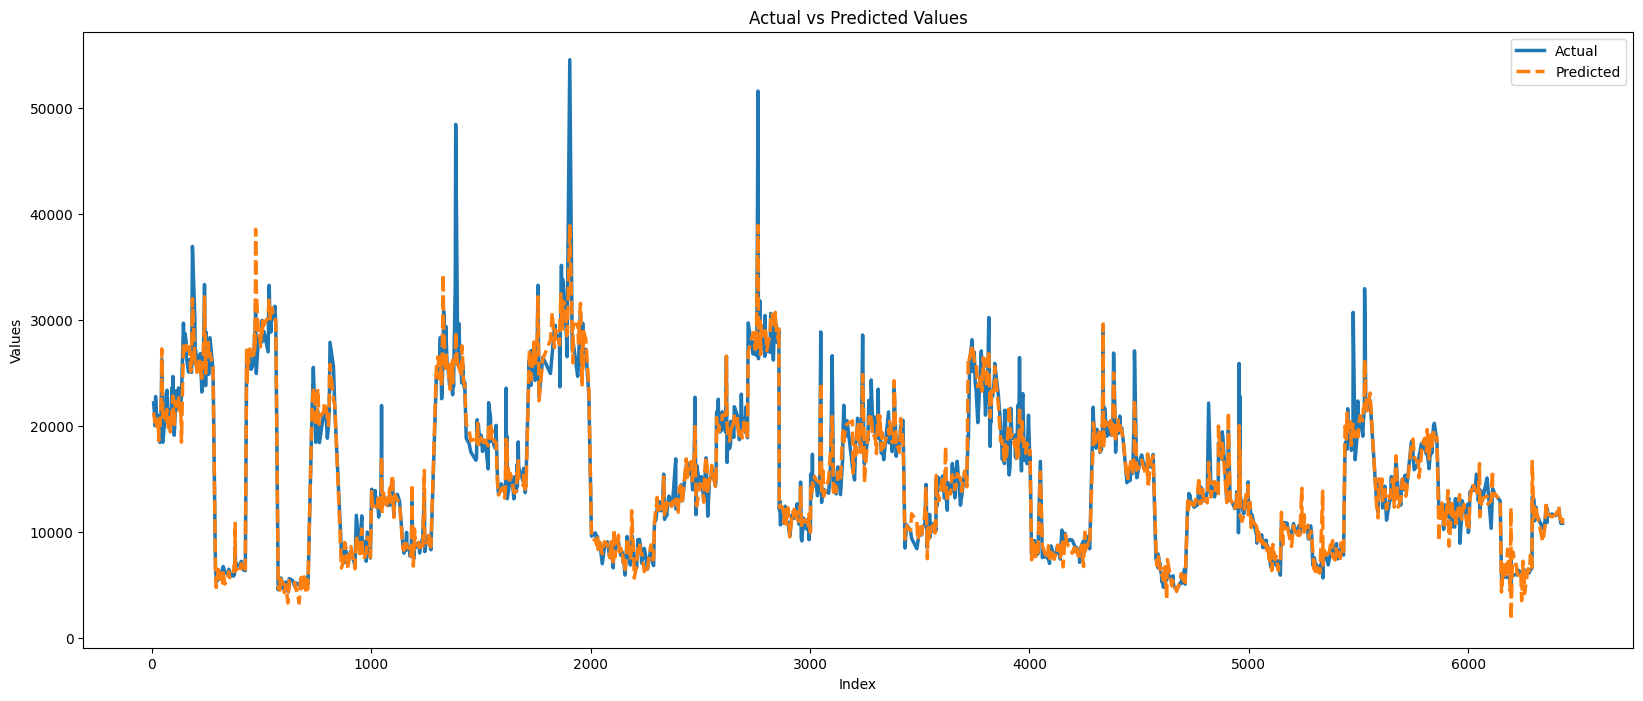

In [97]:
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_xgb
})

plt.figure(figsize=(20, 8))
sns.lineplot(data=results_df, linewidth=2.5,)
plt.title("Actual vs Predicted Values")
plt.xlabel("Index")
plt.ylabel("Values")
plt.show()